## _This notebook is a work in progress. Please check back in soon to see new models, modifications in control flow, and additional visualizations and notes!_

# Regression Models

## Grouping countries for models
## Creating datasets for groups
### group 1 (cluster 1)
- Algeria, Argentina, Australia, Belgium, Chile, France, Indonesia, Italy, Kazakhstan, Malaysia, Mexico, Netherlands, New Zealand, Nigeria, Poland, Portugal, Romania, South Africa, Spain, Sweden, Thailand, Turkey, Ukraine, United Kingdom, Uzbekistan  
_Note: Saudi Arabia, United Arab Emirates, and Kuwait were originally in the list but removed. Their history of 0.0 in renewable energy makes it impossible to include them without further issues arising._
    
|Model|Train R2|Test R2|Train MSE|Test MSE|
|---|---|---|---|---|
|lin reg|1.0|-1.18|0.04|851.02|
|random forest reg|0.92|0.87|27.99|27.99|
|bayesian: st.dev = 1.75, skew = 1|0.8|0.64|35.97|140.38|

### group2 2 (cluster 2)
- Norway
    
|Model|Train R2|Test R2|Train MSE|Test MSE|
|---|---|---|---|---|
|lin reg|1.0|0.0|0.0|455.19|
|random forest reg|0.0|0.0|0.0|0.0|

### group3 3 (clusters 0, 3, 4)
- US, China, Brazil
    
|Model|Train R2|Test R2|Train MSE|Test MSE|
|---|---|---|---|---|
|lin reg|1.0|1.0|0.0|544.07|
|random forest reg|0.65|0.63|55893.92|55893.92|
|Bayesian autoregression|0.24|0.41|48374.17|131346.0|

### group 4 (cluster 5)
- Canada, Colombia, Germany, India, Japan
    
|Model|Train R2|Test R2|Train MSE|Test MSE|
|---|---|---|---|---|
|lin reg|1.0|0.99|0.0|124.99|
|random forest reg|0.71|0.69|3980.38|3980.38|

## Notebook Contents
- [Grouping countries & dataframe subsets](#location)
- [standard regressions](#regressions)
- [autoregressive models](#autoregressions)
- [Developing the Bayesian regression process](#bayesian_development)
- [Bayesian regression](#bayesian)
- [Summary of outputs](#summary) 

Further analysis of these models and comparisons to other models can be found in the [Model Comparison notebook](https://github.com/sonyah-hawaii/time_series_regressive_modeling/blob/master/Model%20Comparison.ipynb)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

import warnings
warnings.simplefilter("ignore")


from pymc3 import Model, Normal, HalfNormal, SkewNormal
from pymc3 import find_MAP
from pymc3 import NUTS, sample
from scipy import optimize
from pymc3 import traceplot
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [3]:
abatement_historical = pd.read_csv('./Data/abatement_calculations.csv')

In [4]:
abatement_historical.set_index('country', inplace=True)
abatement_historical = abatement_historical

In [8]:
#creating subsets based on labels
group_1 = abatement_historical[abatement_historical.label==1]
group_2 = abatement_historical[abatement_historical.label==2]
group_3 = abatement_historical.loc[(abatement_historical.label==0)
                                         |(abatement_historical.label==3)
                                        |(abatement_historical.label==4)]
group_4 = abatement_historical[abatement_historical.label==5]

In [9]:
#In order to avoid errors I have to remove Saudia Arabia and UAE from our cohort.
#They have a steady history of 0 abatement, so they won't be able to work within the bayesian regression, and will affect results of the traditional regressions
group_1.drop(['Saudi Arabia', 'United Arab Emirates', 'Kuwait'], axis=0, inplace=True)

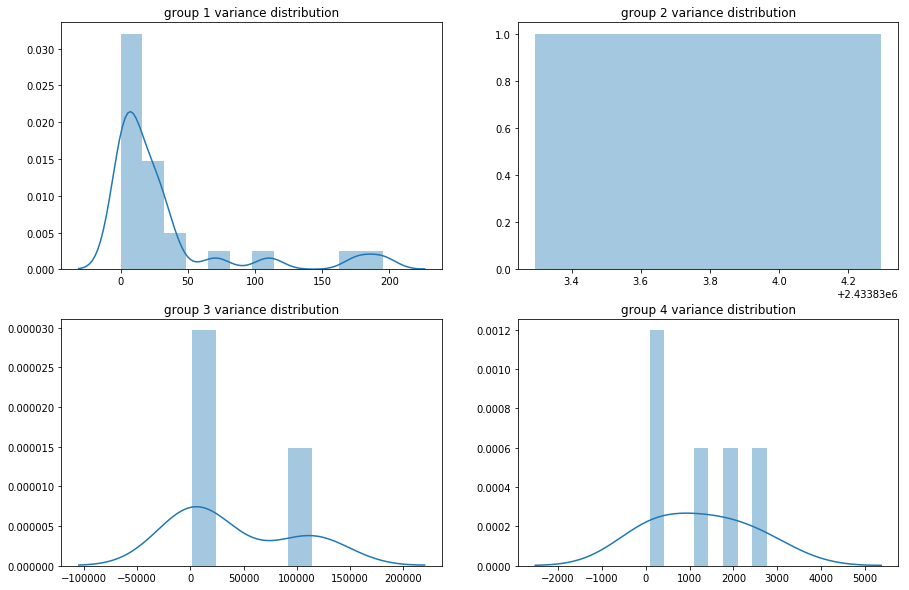

In [11]:
#checking out the distributions of each grouping
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.distplot(group_1.drop('label', axis=1).T.var());
plt.title('group 1 variance distribution');

plt.subplot(2,2,2)
sns.distplot(group_2.drop('label', axis=1).T.var());
plt.title('group 2 variance distribution');

plt.subplot(2,2,3)
sns.distplot(group_3.drop('label', axis=1).T.var(), bins=5);
plt.title('group 3 variance distribution');

plt.subplot(2,2,4)
sns.distplot(group_4.drop('label', axis=1).T.var(), bins=8);
plt.title('group 4 variance distribution');

## Standard Regressions
<a id='regressions'></a>
_These scores will act as a baseline. This way we can understand a little bit more about how Bayesian modeling is contributing or not contributing to our understanding of future values._

### Regression Formula
$$y_{t} = \beta_0 + \sum_{i=1}^{t}\beta_i y_{t-i} +  \sum_{i=1}^{N}\beta_j x_{ji}$$ 

### Baseline
Autoregressive model

In [14]:
dataset = pd.DataFrame()
dataset['target'] = abatement_historical.T.iloc[:,0]
for n in range(1, 16):
    dataset[f'lag{n}'] = dataset['target'].shift(n)
dataset = dataset.loc['2005':]
X = dataset[1:-2]
X_test = dataset[-2:-1]
y = X['target']
y_test = X_test['target']

In [15]:
X.drop('target', axis=1, inplace=True)
X_test.drop('target', axis=1, inplace=True)

In [16]:
lr = LinearRegression()
lr.fit(X, y)
lr.predict(X_test)

rf = RandomForestRegressor(random_state=94)
rf.fit(X, y)
rf.predict(X_test)


print(f'|lin reg|{np.round(lr.score(X, y), 2)}|{np.round(lr.score(X_test, y_test), 2)}|{np.round(mean_squared_error(y, lr.predict(X)), 2)}|{np.round(mean_squared_error(y_test, lr.predict(X_test)), 2)}|')
print(f'|random forest reg|{np.round(rf.score(X, y), 2)}|{np.round(rf.score(X_test, y_test), 2)}|{np.round(mean_squared_error(y, rf.predict(X)), 2)}|{np.round(mean_squared_error(y, rf.predict(X)), 2)}|')
print('\n')

|lin reg|1.0|0.0|0.0|0.01|
|random forest reg|0.8|0.0|0.0|0.0|




##### So this does show that including everything in a standard autoregressive model is truly ineffective. There's integrity loss for every single predicted datapoint, as reflected by the 

In [17]:
#Code to generate predictions and results for summary table
subsets = ['regression_1', 'regression_2','regression_3','regression_4']

for i in subsets:
    #generating scores
    dataset = pd.DataFrame()
    dataset['target'] = eval(i).T.iloc[:,0]
    for n in range(1, 16):
        dataset[f'lag{n}'] = dataset['target'].shift(n)
    dataset = dataset.loc['2005':]
    X = dataset[1:-2]
    X_test = dataset[-2:-1]
    y = X['target']
    y_test = X_test['target']

    y = np.array(y).reshape(-1,1)
    #X = np.array(train.drop('target', axis=1))
    ss = StandardScaler()
    X = ss.fit_transform(X)
    #X_test = ss.transform(test.drop('target', axis=1))
    y_test = y_test

    #generating linear regression outputs
    lr = LinearRegression()
    lr.fit(X, y)
    lr.predict(X_test)
    
    #generating random forest regressor outputs
    rf = RandomForestRegressor(random_state=94)
    rf.fit(X, y)
    rf.predict(X_test)
    
    #printing out structure for summary table
    print(f'|{i}|lin reg|{np.round(lr.score(X, y), 2)}|{np.round(lr.score(X_test, y_test), 2)}|{np.round(mean_squared_error(y, lr.predict(X)), 2)}|{np.round(mean_squared_error(y_test, lr.predict(X_test)), 2)}|')
    print(f'|{i}|random forest reg|{np.round(rf.score(X, y), 2)}|{np.round(rf.score(X_test, y_test), 2)}|{np.round(mean_squared_error(y, rf.predict(X)), 2)}|{np.round(mean_squared_error(y, rf.predict(X)), 2)}|')
    print('\n')
#     #generating plots
#     plt.figure(figsize=(30,5))
#     plt.plot(lr.predict(X_test), label='predictions lr');
#     plt.plot(rf.predict(X_test), label='predictions rf');
#     plt.plot(y_test, label='yi');
#     plt.legend();

|regression_1|lin reg|1.0|0.0|0.0|0.02|
|regression_1|random forest reg|0.78|0.0|0.0|0.0|


|regression_2|lin reg|1.0|0.0|0.0|1230417248345.76|
|regression_2|random forest reg|0.9|0.0|50054.38|50054.38|


|regression_3|lin reg|1.0|0.0|0.0|38932900.04|
|regression_3|random forest reg|0.79|0.0|284.43|284.43|


|regression_4|lin reg|1.0|0.0|0.0|110661280.14|
|regression_4|random forest reg|0.87|0.0|72.11|72.11|




## Bayesian Regression Development
<a id='bayesian_development'></a>

This process was adapted from a notebook developd by Phillippa Thomson

$$y_{t} = \beta_0 + \sum_{i=1}^{t}\beta_i y_{t-i} +  \sum_{i=1}^{N}\beta_j x_{ji} + \epsilon_i$$ 

   
$$\beta_0 \sim Skew Normal(1.75, 1)$$

$$\beta_1 \sim Skew Normal(1.75, 1)$$

$$\epsilon \sim Half Normal(1, 0)$$


In [289]:
#building lagged dataframe
dataset = pd.DataFrame()
dataset['target'] = regression_1[regression_1.index=='Algeria'].T.iloc[:,0]
for i in range(1, 16):
    dataset[f'lag{i}'] = dataset['target'].shift(i)

dataset = dataset.loc['2005':]
train = dataset[0:5]
val = dataset[5:-1]
test = dataset[-1:]

#setting up train, val, test
train_target = train['target']
val_target = val['target']
test_target = test['target']

#setting up x and y for MCMC
y = np.array(train_target).reshape(-1,1)
X = np.array(train.drop('target', axis=1))
ss = StandardScaler()
X = ss.fit_transform(X)

#setting standard deviation to feed into the mcmc model
mcmc_std = train_target.std()

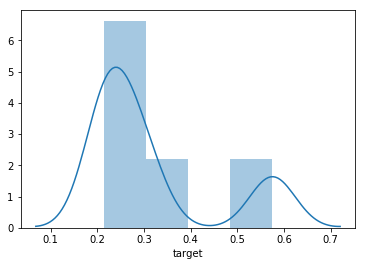

In [290]:
sns.distplot(train_target);

In [291]:
#priors definitions
#likelihood equation set up
#structure set up here

basic_model = Model()
with basic_model:
    # start by defining distribution for all parameters
    # use sd to determine strength of the prior
    # big sd is a weak prior
    intercept = Normal('intercept', mu=0, sd=mcmc_std)
    # the shape on beta is the number of features in the fit
    beta = Normal('beta', mu=0, sd=mcmc_std, shape=15)
    # sigma is the width of the gaussian around yhat
    # (i.e. related to the size of the residuals)
    sigma = HalfNormal('sigma', sd=1)

    # create a formula for yhat
    y_hat = intercept + beta * X

    # simulate data as a distribution around yhat
    Y_obs = Normal('Y_obs', mu=y_hat, sd=sigma, observed=y)

In [292]:
#posterior calculations
#not full MCMC but giving you an estimate of the most likely values for unknown coefficients
map_estimate = find_MAP(model=basic_model)
print(map_estimate)

logp = 64.645, ||grad|| = 5.6045: 100%|██████████| 17/17 [00:00<00:00, 1300.58it/s]  

{'intercept': array(0.3112147), 'beta': array([-0.02692581, -0.0246623 , -0.0783784 , -0.03466686, -0.02947492,
        0.07864392,  0.06449008, -0.05876225, -0.01415467,  0.06848933,
        0.01724879,  0.09271555, -0.01695529,  0.03951225, -0.07173919]), 'sigma_log__': array(-2.11787321), 'sigma': array(0.12028718)}


In [293]:
#this component is doing the sampling of those distributions
#mcmc

with basic_model:
    trace = sample(2000,cores=1) #set to sample twice so your predictions can be compared

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_log__, beta, intercept]
100%|██████████| 2500/2500 [00:04<00:00, 561.18it/s]


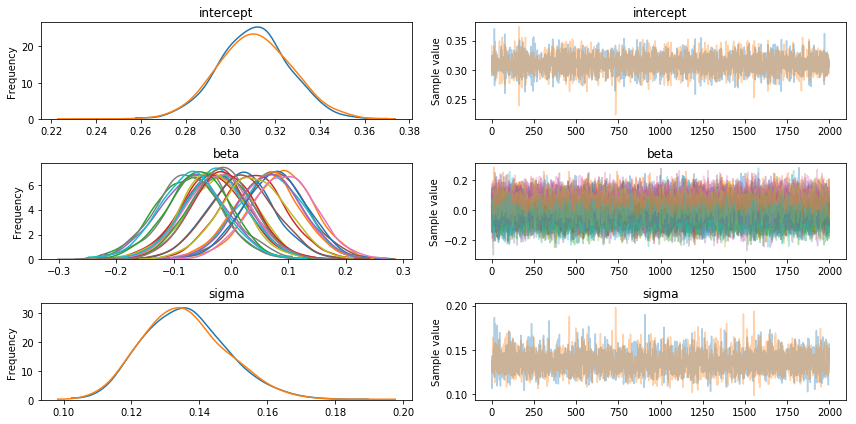

In [86]:
#look into breaking this stuff apart for better analysis

#intercept is the posterior
#the data informed the uncertainty around the intercept
#which forced it to be smaller and better align with the data 
traceplot(trace);

In [87]:
#takes in inputs (X) and generates an entire range of 2000 predictions (y_hat)

preds_train = []
for i in trace:
    sigma = i['sigma']
    eps = np.random.normal(0, sigma)
    y_hat = i['intercept'] + np.matmul(X, i['beta']) + eps
    preds_train.append(y_hat)
    
avg_preds_train = []
for i in preds_train:
    avg_preds_train.append(i.mean())

In [88]:
y_val = np.array(val_target).reshape(-1,1)
X_val = np.array(val.drop('target', axis=1))
ss_val = StandardScaler()
X_val = ss.fit_transform(X_val)

preds_val = []
for i in trace:
    sigma = i['sigma']
    eps = np.random.normal(0, sigma)
    y_hat = i['intercept'] + np.matmul(X_val, i['beta']) + eps
    preds_val.append(y_hat)
    
avg_preds_val = []
for i in preds_val:
    avg_preds_val.append(i.mean())

In [100]:
y_test = np.array(test_target).reshape(-1,1)
X_test = np.array(test.drop('target', axis=1))
ss_test = StandardScaler()
X_test = ss.fit_transform(X_test)

preds_test = []
for i in trace:
    sigma = i['sigma']
    eps = np.random.normal(0, sigma)
    y_hat = i['intercept'] + np.matmul(X_test, i['beta']) + eps
    preds_test.append(y_hat)
    
# avg_preds_test = []
# for i in preds_test:
#     avg_preds_test.append(i.mean())

In [59]:
pd.DataFrame(avg_preds_test).skew(), pd.DataFrame(avg_preds_test).kurt()

(0    0.040072
 dtype: float64, 0    0.001989
 dtype: float64)

## Bayesian Regression for Cohort 1
<a id='bayesian'></a>


WARNING: RUN THIS CELL AT YOUR OWN RISK (long print out and takes forever)

In [7]:
#building lagged dataframe and running it through a regression
train_yi = []
train_preds = []

test_yi = []
test_preds = []

for i in regression_1.index:
    dataset = pd.DataFrame()
    dataset['target'] = regression_1[regression_1.index==i].T.iloc[:,0]
    for n in range(1, 16):
        dataset[f'lag{n}'] = dataset['target'].shift(n)
    dataset = dataset.loc['2005':]
    train = dataset[0:-2]
    test = dataset[-2:-1]
    
    #setting up train, val, test
    train_target = train['target']
    for y in train_target:
        train_yi.append(y)
    test_target = test['target']
    for h in test_target:
        test_yi.append(h)

    #setting up x and y for MCMC
    y = np.array(train_target).reshape(-1,1)
    X = train.drop('target', axis=1)
    ss = StandardScaler()
    X = ss.fit_transform(X)

    #setting standard deviation to feed into the mcmc model
    mcmc_std = train_target.std()
    
    #Building model
    basic_model = Model()
    with basic_model:
        # start by defining distribution for all parameters
        # use sd to determine strength of the prior
        # big sd is a weak prior
        intercept = Normal('intercept', mu=0, sd=mcmc_std)
        # the shape on beta is the number of features in the fit
        beta = Normal('beta', mu=0, sd=mcmc_std, shape=15)
        # sigma is the width of the gaussian around yhat
        # (i.e. related to the size of the residuals)
        sigma = HalfNormal('sigma', sd=1)

        # create a formula for yhat
        y_hat = intercept + beta * X

        # simulate data as a distribution around yhat
        Y_obs = Normal('Y_obs', mu=y_hat, sd=sigma, observed=y)

        map_estimate = find_MAP(model=basic_model)
    with basic_model:
        trace = sample(5000,cores=1) #set to sample twice so your predictions can be compared
        
    #takes in inputs (X) and generates an entire range of 2000 predictions (y_hat)
    preds_train = []
    for i in trace:
        sigma = i['sigma']
        eps = np.random.normal(0, sigma)
        y_hat = i['intercept'] + np.matmul(X, i['beta']) + eps
        preds_train.append(y_hat)
        
        
    #_____________________________________________________________      
        
    #generating predictions for the train dataset
    avg_preds_train = []
    for i in pd.DataFrame(preds_train):
        train_preds.append(np.mean(pd.DataFrame(preds_train)[i]))

    #setting x and y for test predictions
    y_test = np.array(test_target).reshape(-1,1)
    X_test = np.array(test.drop('target', axis=1))
    ss_test = StandardScaler()
    X_test = ss.fit_transform(X_test)
    
    #generating predictions for the test set
    preds_test = []
    for i in trace:
        sigma = i['sigma']
        eps = np.random.normal(0, sigma)
        y_hat = i['intercept'] + np.matmul(X_test, i['beta']) + eps
        preds_test.append(y_hat)
    avg_preds_test = []
    for i in pd.DataFrame(preds_test): 
        test_preds.append(np.mean(pd.DataFrame(preds_test)[i]))

logp = 100.64, ||grad|| = 11.61: 100%|██████████| 17/17 [00:00<00:00, 778.28it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_log__, beta, intercept]
100%|██████████| 5500/5500 [00:09<00:00, 605.57it/s]
logp = -431.44, ||grad|| = 0.98678: 100%|██████████| 35/35 [00:00<00:00, 1406.59it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_log__, beta, intercept]
100%|██████████| 5500/5500 [00:10<00:00, 527.13it/s]
logp = -415.88, ||grad|| = 0.0015831: 100%|██████████| 33/33 [00:00<00:00, 1306.06it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_log__, beta, intercept]
100%|██████████| 5500/5500 [00:10<00:00, 519.51it/s]
The acceptance probability does not match the target. It is 0.8877923099106633, but should be close to 0.8. Try to incre

In [9]:
print(f'|1|Bayesian autoregression|{np.round(r2_score(train_yi, train_predictions), 2)}|{np.round(r2_score(test_yi, test_predictions), 2)}\
|{np.round(mean_squared_error(train_yi, train_predictions), 2)}|{np.round(mean_squared_error(test_yi, test_predictions), 2)}|')

ValueError: Found input variables with inconsistent numbers of samples: [225, 0]

- build a dataframe where features are lagged timepoints
- target is the next feature in the progression  
  
- specify priors on all coefficients
- specify priors on variance of data
- plug things into the model 
- follow pymc3 lesson

- goal is actually a posterior predictive
- pyflux provides uncertainty bounds (UL + LL)
- for a highly generalized bayesian regression try pymc3
    - you  need to specify priors and distributions
    - begin with something relatively uninformative (broad gaussian, uniform, etc.) 
    
1. write out an equation, which model inteded (ex. regression + variance)
2. specify priors for each coefficient, prior on variance
    - pymc3 this means creating new objects 
3. take existing objects/variables that contain priors and build a likelihood distribution with observed data
    - prior variables act as parameters
    - MCMC
4. estimate y-hat and save values
    - this is where we capture variance
    - write out a function to pull samples from these distributions
    - codify the samples pulled, **construct a distribution of y-hat** fitting to obtain bounds and represent uncertainty or anticipated variance
        - we can use this to set a confidence interval
    - combining these observations to understand uncertainty is where this gets shaky

## Bayesian Regression for Cohort 3

In [36]:
#building lagged dataframe
train_yi = []
train_preds = []
test_yi = []
test_preds = []
for i in regression_3.index:
    dataset = pd.DataFrame()
    dataset['target'] = regression_3[regression_3.index==i].T.iloc[:,0]
    for n in range(1, 16):
        dataset[f'lag{n}'] = dataset['target'].shift(n)
    dataset = dataset.loc['2005':]
    train = dataset[0:-2]
    test = dataset[-2:-1]
    
    #setting up train, val, test
    train_target = train['target']
    for y in train_target:
        train_yi.append(y)
    test_target = test['target']
    for h in test_target:
        test_yi.append(h)

    #setting up x and y for MCMC
    y = np.array(train_target).reshape(-1,1)
    X = train.drop('target', axis=1)
    ss = StandardScaler()
    X = ss.fit_transform(X)

    #setting standard deviation to feed into the mcmc model
    mcmc_std = train_target.std()
    
    #Building model
    basic_model = Model()
    with basic_model:
        # start by defining distribution for all parameters
        # use sd to determine strength of the prior
        # big sd is a weak prior
        intercept = Normal('intercept', mu=1, sd=mcmc_std)
        # the shape on beta is the number of features in the fit
        beta = Normal('beta', mu=1, sd=mcmc_std, shape=15)
        # sigma is the width of the gaussian around yhat
        # (i.e. related to the size of the residuals)
        sigma = HalfNormal('sigma', sd=1)

        # create a formula for yhat
        y_hat = intercept + beta * X

        # simulate data as a distribution around yhat
        Y_obs = Normal('Y_obs', mu=y_hat, sd=sigma, observed=y)

        map_estimate = find_MAP(model=basic_model)
    with basic_model:
        trace = sample(2000,cores=1) #set to sample twice so your predictions can be compared
        
    #takes in inputs (X) and generates an entire range of 2000 predictions (y_hat)
    preds_train = []
    for i in trace:
        sigma = i['sigma']
        eps = np.random.normal(0, sigma)
        y_hat = i['intercept'] + np.matmul(X, i['beta']) + eps
        preds_train.append(y_hat)

    #generating predictions for the train dataset
    avg_preds_train = []
    for i in pd.DataFrame(preds_train):
        avg_preds_train.append(np.mean(preds_train[i]))
    
    #setting x and y for test predictions
    y_test = np.array(test_target).reshape(-1,1)
    X_test = np.array(test.drop('target', axis=1))
    ss_test = StandardScaler()
    X_test = ss.fit_transform(X_test)
    
     #generating predictions for the test set
    preds_test = []
    for i in trace:
        sigma = i['sigma']
        eps = np.random.normal(0, sigma)
        y_hat = i['intercept'] + np.matmul(X_test, i['beta']) + eps
        preds_test.append(y_hat)
    avg_preds_test = []
    for i in pd.DataFrame(preds_test):
        avg_preds_test.append(np.mean(preds_test[i]))   
    train_preds.append([p for p in avg_preds_train])
    test_preds.append([q for q in avg_preds_test])

logp = -1,039.8, ||grad|| = 0.042853: 100%|██████████| 53/53 [00:00<00:00, 1196.82it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_log__, beta, intercept]
100%|██████████| 2500/2500 [05:31<00:00,  7.53it/s]
The acceptance probability does not match the target. It is 0.9894344705449432, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9918094634737621, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
logp 

ValueError: Mass matrix contains zeros on the diagonal. Some derivatives might always be zero.

In [ ]:
train_predictions = []
for i in train_preds:
    for n in i:
        train_predictions.append(n)
        
test_predictions = []
for i in test_preds:
    for n in i:
        test_predictions.append(n)

In [316]:
print(f'|3|Bayesian autoregression|{np.round(r2_score(train_yi, train_predictions), 2)}|{np.round(r2_score(test_yi, test_predictions), 2)}\
|{np.round(mean_squared_error(train_yi, train_predictions), 2)}|{np.round(mean_squared_error(test_yi, test_predictions), 2)}|')

|3|Bayesian autoregression|0.24|0.41|48374.17|131346.0|


## Summary
<a id='summary'></a>

In [ ]:
train_target

In [29]:
#building lagged dataframe
train_yi = []
train_preds = []
test_yi = []
test_preds = []
for i in regression_1.index:
    dataset = pd.DataFrame()
    dataset['target'] = regression_1[regression_1.index==i].T.iloc[:,0]
    for n in range(1, 16):
        dataset[f'lag{n}'] = dataset['target'].shift(n)
    dataset = dataset.loc['2005':]
    train = dataset[0:-2]
    test = dataset[-2:-1]
    
    #setting up train, val, test
    train_target = train['target']
    for y in train_target:
        train_yi.append(y)
    test_target = test['target']
    for h in test_target:
        test_yi.append(h)

    #setting up x and y for MCMC
    y = np.array(train_target).reshape(-1,1)
    X = train.drop('target', axis=1)
    ss = StandardScaler()
    X = ss.fit_transform(X)

    #setting standard deviation to feed into the mcmc model
    mcmc_std = train_target.std()
    
    #Building model
    basic_model = Model()
    with basic_model:
        # start by defining distribution for all parameters
        # use sd to determine strength of the prior
        # big sd is a weak prior
        intercept = SkewNormal('intercept', mu=0, sd=mcmc_std, alpha=0.9)
        # the shape on beta is the number of features in the fit
        beta = SkewNormal('beta', mu=0, sd=mcmc_std, shape=15, alpha=0.9)
        # sigma is the width of the gaussian around yhat
        # (i.e. related to the size of the residuals)
        sigma = HalfNormal('sigma', sd=1)

        # create a formula for yhat
        y_hat = intercept + beta * X

        # simulate data as a distribution around yhat
        Y_obs = Normal('Y_obs', mu=y_hat, sd=sigma, observed=y)

        map_estimate = find_MAP(model=basic_model)
    with basic_model:
        trace = sample(2000,cores=1) #set to sample twice so your predictions can be compared
        
    #takes in inputs (X) and generates an entire range of 2000 predictions (y_hat)
    preds_train = []
    for i in trace:
        sigma = i['sigma']
        eps = np.random.normal(0, sigma)
        y_hat = i['intercept'] + np.matmul(X, i['beta']) + eps
        preds_train.append(y_hat)

    #generating predictions for the train dataset
    avg_preds_train = []
    for i in pd.DataFrame(preds_train):
        avg_preds_train.append(np.mean(preds_train[i]))
    
    #setting x and y for test predictions
    y_test = np.array(test_target).reshape(-1,1)
    X_test = np.array(test.drop('target', axis=1))
    ss_test = StandardScaler()
    X_test = ss.fit_transform(X_test)
    
     #generating predictions for the test set
    preds_test = []
    for i in trace:
        sigma = i['sigma']
        eps = np.random.normal(0, sigma)
        y_hat = i['intercept'] + np.matmul(X_test, i['beta']) + eps
        preds_test.append(y_hat)
    avg_preds_test = []
    for i in pd.DataFrame(preds_test):
        avg_preds_test.append(np.mean(preds_test[i]))   
    train_preds.append([p for p in avg_preds_train])
    test_preds.append([q for q in avg_preds_test])

logp = 100.99, ||grad|| = 1.3037: 100%|██████████| 15/15 [00:00<00:00, 1005.23it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_log__, beta, intercept]
100%|██████████| 2500/2500 [00:08<00:00, 288.70it/s]
logp = -429.95, ||grad|| = 1.5282: 100%|██████████| 37/37 [00:00<00:00, 1382.42it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_log__, beta, intercept]
100%|██████████| 2500/2500 [00:06<00:00, 359.51it/s]
logp = -410.79, ||grad|| = 0.0014749: 100%|██████████| 42/42 [00:00<00:00, 1155.44it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_log__, beta, intercept]
100%|██████████| 2500/2500 [00:09<00:00, 276.76it/s]
logp = -123.56, ||grad|| = 31.623: 100%|██████████| 19/19 [00:00<00:00, 789.96it/s]  
Auto-assigning NUTS sampler...
In

In [30]:
train_predictions = []
for i in train_preds:
    for n in i:
        train_predictions.append(n)
        
test_predictions = []
for i in test_preds:
    for n in i:
        test_predictions.append(n)

In [31]:
print(f'|Bayesian autoregression|{np.round(r2_score(train_yi, train_predictions), 2)}|{np.round(r2_score(test_yi, test_predictions), 2)}\
|{np.round(mean_squared_error(train_yi, train_predictions), 2)}|{np.round(mean_squared_error(test_yi, test_predictions), 2)}|')

|Bayesian autoregression|0.78|0.58|39.17|162.7|


#old outputs stored 

|normal distribution, st.dev = 1.75|0.61|45.87|151.34|    
|skew normal, st.dev = 1.75, skew = 1|0.8|0.64|35.97|140.38|  
|skew normal, st.dev = 3.5, skew = 1|0.81|0.61|33.37|152.53|  
|skew normal, st.dev = 3.5, skew = 1.5|0.78|0.58|39.17|162.7|